# Libraries

In [18]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


device: cuda


# Data Loading


In [19]:
# from google.colab import drive
# drive.mount('/content/drive')

data_path = "/kaggle/input/car-data/car_data" # "/content/drive/MyDrive/car_data"



In [20]:
def load(data_path, max_files=None):
    X_all, y_all = [], []

    files = sorted([f for f in os.listdir(data_path) if f.endswith('.csv')])
    if max_files:
        files = files[:max_files]

    for fname in tqdm(files):
        df = pd.read_csv(os.path.join(data_path, fname))
        if df.shape[0] < 67:
            continue

        # Separate scalers for input (12 features) and target (2 features)
        input_scaler = MinMaxScaler()
        target_scaler = MinMaxScaler()

        input_seq = input_scaler.fit_transform(df.iloc[:62].values)  # 62×12
        target_seq = target_scaler.fit_transform(df.iloc[62:67][['Local_X', 'Local_Y']].values)  # 5×2

        X_all.append(input_seq)
        y_all.append(target_seq)

    return np.array(X_all), np.array(y_all)


# Data Splitting

In [21]:
X_data, y_data = load(data_path, max_files=9400)

X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val:   {X_val.shape}, {y_val.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}")


100%|██████████| 9400/9400 [00:38<00:00, 247.17it/s]


Train: (6580, 62, 12), (6580, 5, 2)
Val:   (1410, 62, 12), (1410, 5, 2)
Test:  (1410, 62, 12), (1410, 5, 2)


# Dataset Loaders

In [22]:
class CarDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 128
train_loader = DataLoader(CarDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(CarDataset(X_val, y_val), batch_size=batch_size)
test_loader  = DataLoader(CarDataset(X_test, y_test), batch_size=batch_size)


# LSTM Custom Design

In [23]:
class LSTM(nn.Module):
    def __init__(self, input_size=12, hidden_size=128, output_size=2, output_steps=5, dropout=0.2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.output_steps = output_steps
        self.dropout = nn.Dropout(dropout)
        self.projection = nn.Linear(hidden_size, output_size)

        # LSTM Gate weights and biases
        self.W_xi = nn.Parameter(torch.empty(input_size, hidden_size))
        self.W_hi = nn.Parameter(torch.empty(hidden_size, hidden_size))
        self.b_i  = nn.Parameter(torch.zeros(hidden_size))

        self.W_xf = nn.Parameter(torch.empty(input_size, hidden_size))
        self.W_hf = nn.Parameter(torch.empty(hidden_size, hidden_size))
        self.b_f  = nn.Parameter(torch.zeros(hidden_size))

        self.W_xc = nn.Parameter(torch.empty(input_size, hidden_size))
        self.W_hc = nn.Parameter(torch.empty(hidden_size, hidden_size))
        self.b_c  = nn.Parameter(torch.zeros(hidden_size))

        self.W_xo = nn.Parameter(torch.empty(input_size, hidden_size))
        self.W_ho = nn.Parameter(torch.empty(hidden_size, hidden_size))
        self.b_o  = nn.Parameter(torch.zeros(hidden_size))

        # Xavier
        for w in [self.W_xi, self.W_hi, self.W_xf, self.W_hf,
                  self.W_xc, self.W_hc, self.W_xo, self.W_ho]:
            nn.init.xavier_uniform_(w)

    def lstm_cell(self, x_t, h_prev, c_prev):
        i = torch.sigmoid(x_t @ self.W_xi + h_prev @ self.W_hi + self.b_i)
        f = torch.sigmoid(x_t @ self.W_xf + h_prev @ self.W_hf + self.b_f)
        g = torch.tanh(x_t @ self.W_xc + h_prev @ self.W_hc + self.b_c)
        o = torch.sigmoid(x_t @ self.W_xo + h_prev @ self.W_ho + self.b_o)

        c_t = f * c_prev + i * g
        h_t = o * torch.tanh(c_t)
        return self.dropout(h_t), c_t

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

        for t in range(seq_len):
            h_t, c_t = self.lstm_cell(x[:, t, :], h_t, c_t)

        # predicting next 5 datapints
        outputs = []
        x_next = x[:, -1, :]
        for _ in range(self.output_steps):
            h_t, c_t = self.lstm_cell(x_next, h_t, c_t)
            pred = self.projection(h_t)
            outputs.append(pred)
            x_next = torch.cat([pred, x_next[:, 2:]], dim=1) 

        return torch.stack(outputs, dim=1)  # (batch, 5, 2)


# Training, Validation and Testing Loops

In [24]:
def RMSELoss(pred, target):
    return torch.sqrt(torch.mean((pred - target) ** 2))
    
# Training
def train_model(config, model, train_loader, val_loader, device='cuda'):
    lr = config["lr"]
    epochs = config["epochs"]
    name = config["name"]

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    criterion = RMSELoss

    train_rmse = []
    val_rmse = []

    for epoch in range(1, epochs + 1):
        model.train()
        running_train_loss = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_rmse.append(avg_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                running_val_loss += loss.item()
        avg_val_loss = running_val_loss / len(val_loader)
        val_rmse.append(avg_val_loss)

        scheduler.step(avg_val_loss)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs} | {name} | Train RMSE: {avg_train_loss:.4f} | Val RMSE: {avg_val_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

    return model, train_rmse, val_rmse

# Testing
def test(model, test_loader, device='cuda'):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = RMSELoss(pred, yb)
            total_loss += loss.item()
    avg_loss = total_loss / len(test_loader)
    return avg_loss

# Experiments and Results

In [25]:
def experiments(configs):
    results = []

    for cfg in configs:
        print(f"\n config: {cfg['name']}")
        model = LSTM(
            input_size=12,
            hidden_size=cfg["hidden_size"],
            output_size=2,
            output_steps=5,
            dropout=cfg["dropout"]
        )

        model, train_loss, val_loss = train_model(cfg, model, train_loader, val_loader, device=device)
        test_loss = test(model, test_loader, device=device)

        results.append({
            "name": cfg["name"],
            "train_loss": train_loss,
            "val_loss": val_loss,
            "test_loss": test_loss
        })


        plt.figure(figsize=(10, 4))
        epochs = range(1, len(train_loss) + 1)
        plt.plot(epochs, train_loss, 'b--', label='Train RMSE')
        plt.plot(epochs, val_loss, 'r-', label='Val RMSE')
        plt.title(f"RMSE Curve: {cfg['name']}")
        plt.xlabel("Epoch")
        plt.ylabel("RMSE")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    print("\n Final Test RMSEs:")
    for r in results:
        print(f"{r['name']:<25} - Test RMSE: {r['test_loss']:.4f}")

    return results


# Testing on Different Model Configurations 


 config: model_1
Epoch 10/200 | model_1 | Train RMSE: 0.2638 | Val RMSE: 0.2609 | LR: 0.001000
Epoch 20/200 | model_1 | Train RMSE: 0.2526 | Val RMSE: 0.2500 | LR: 0.001000
Epoch 30/200 | model_1 | Train RMSE: 0.2451 | Val RMSE: 0.2464 | LR: 0.001000
Epoch 40/200 | model_1 | Train RMSE: 0.2401 | Val RMSE: 0.2457 | LR: 0.001000
Epoch 50/200 | model_1 | Train RMSE: 0.2350 | Val RMSE: 0.2426 | LR: 0.001000
Epoch 60/200 | model_1 | Train RMSE: 0.2329 | Val RMSE: 0.2417 | LR: 0.001000
Epoch 70/200 | model_1 | Train RMSE: 0.2264 | Val RMSE: 0.2424 | LR: 0.000500
Epoch 80/200 | model_1 | Train RMSE: 0.2218 | Val RMSE: 0.2426 | LR: 0.000250
Epoch 90/200 | model_1 | Train RMSE: 0.2195 | Val RMSE: 0.2442 | LR: 0.000125
Epoch 100/200 | model_1 | Train RMSE: 0.2175 | Val RMSE: 0.2444 | LR: 0.000125
Epoch 110/200 | model_1 | Train RMSE: 0.2169 | Val RMSE: 0.2439 | LR: 0.000063
Epoch 120/200 | model_1 | Train RMSE: 0.2172 | Val RMSE: 0.2440 | LR: 0.000031
Epoch 130/200 | model_1 | Train RMSE: 0.215

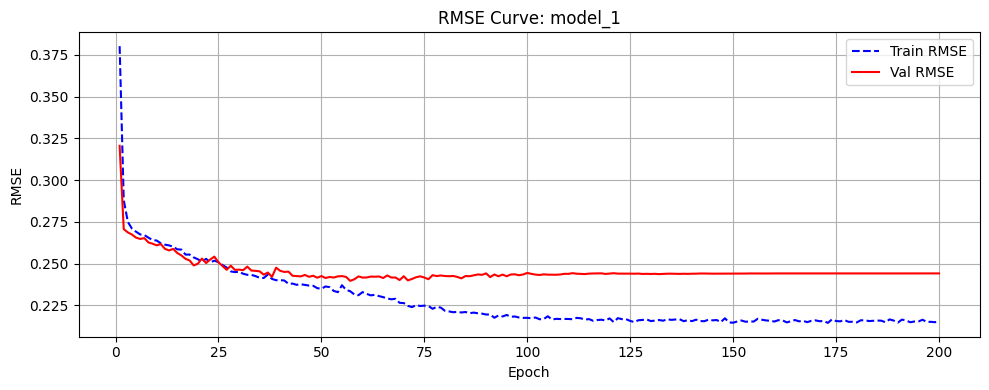


 config: model_2
Epoch 10/100 | model_2 | Train RMSE: 0.2600 | Val RMSE: 0.2599 | LR: 0.001000
Epoch 20/100 | model_2 | Train RMSE: 0.2485 | Val RMSE: 0.2501 | LR: 0.001000
Epoch 30/100 | model_2 | Train RMSE: 0.2377 | Val RMSE: 0.2419 | LR: 0.001000
Epoch 40/100 | model_2 | Train RMSE: 0.2343 | Val RMSE: 0.2394 | LR: 0.001000
Epoch 50/100 | model_2 | Train RMSE: 0.2273 | Val RMSE: 0.2380 | LR: 0.001000
Epoch 60/100 | model_2 | Train RMSE: 0.2220 | Val RMSE: 0.2375 | LR: 0.001000
Epoch 70/100 | model_2 | Train RMSE: 0.2106 | Val RMSE: 0.2425 | LR: 0.000500
Epoch 80/100 | model_2 | Train RMSE: 0.1999 | Val RMSE: 0.2442 | LR: 0.000250
Epoch 90/100 | model_2 | Train RMSE: 0.1928 | Val RMSE: 0.2501 | LR: 0.000125
Epoch 100/100 | model_2 | Train RMSE: 0.1899 | Val RMSE: 0.2514 | LR: 0.000063


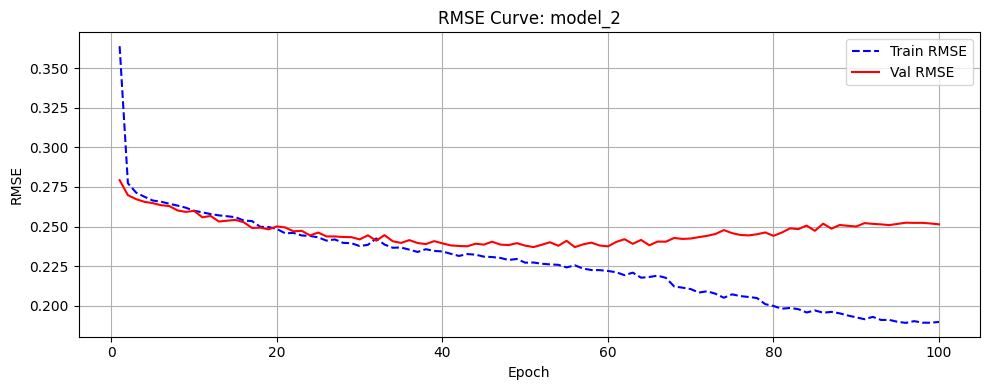


 config: model_3
Epoch 10/100 | model_3 | Train RMSE: 0.2578 | Val RMSE: 0.2578 | LR: 0.001000
Epoch 20/100 | model_3 | Train RMSE: 0.2453 | Val RMSE: 0.2522 | LR: 0.001000
Epoch 30/100 | model_3 | Train RMSE: 0.2374 | Val RMSE: 0.2423 | LR: 0.001000
Epoch 40/100 | model_3 | Train RMSE: 0.2301 | Val RMSE: 0.2355 | LR: 0.001000
Epoch 50/100 | model_3 | Train RMSE: 0.2214 | Val RMSE: 0.2338 | LR: 0.001000
Epoch 60/100 | model_3 | Train RMSE: 0.2091 | Val RMSE: 0.2407 | LR: 0.001000
Epoch 70/100 | model_3 | Train RMSE: 0.1864 | Val RMSE: 0.2471 | LR: 0.000500
Epoch 80/100 | model_3 | Train RMSE: 0.1685 | Val RMSE: 0.2519 | LR: 0.000250
Epoch 90/100 | model_3 | Train RMSE: 0.1568 | Val RMSE: 0.2560 | LR: 0.000125
Epoch 100/100 | model_3 | Train RMSE: 0.1525 | Val RMSE: 0.2598 | LR: 0.000063


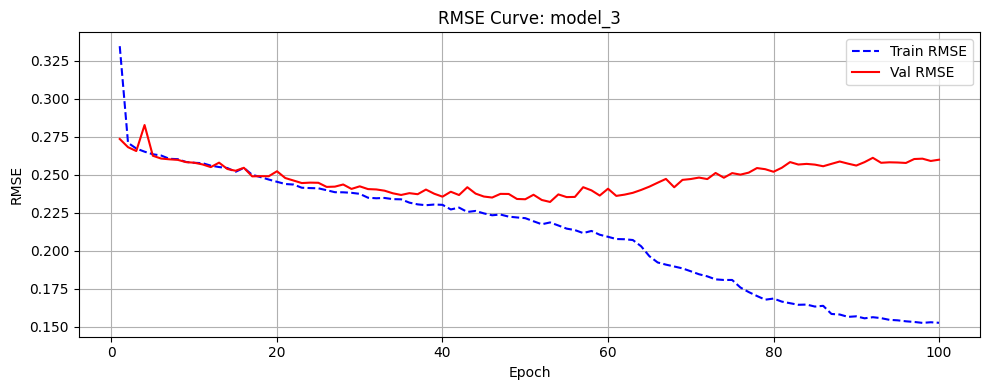


 config: model_4
Epoch 10/80 | model_4 | Train RMSE: 0.2595 | Val RMSE: 0.2567 | LR: 0.001000
Epoch 20/80 | model_4 | Train RMSE: 0.2511 | Val RMSE: 0.2471 | LR: 0.001000
Epoch 30/80 | model_4 | Train RMSE: 0.2416 | Val RMSE: 0.2452 | LR: 0.001000
Epoch 40/80 | model_4 | Train RMSE: 0.2352 | Val RMSE: 0.2388 | LR: 0.001000
Epoch 50/80 | model_4 | Train RMSE: 0.2298 | Val RMSE: 0.2343 | LR: 0.001000
Epoch 60/80 | model_4 | Train RMSE: 0.2244 | Val RMSE: 0.2369 | LR: 0.001000
Epoch 70/80 | model_4 | Train RMSE: 0.2124 | Val RMSE: 0.2383 | LR: 0.000500
Epoch 80/80 | model_4 | Train RMSE: 0.2011 | Val RMSE: 0.2428 | LR: 0.000250


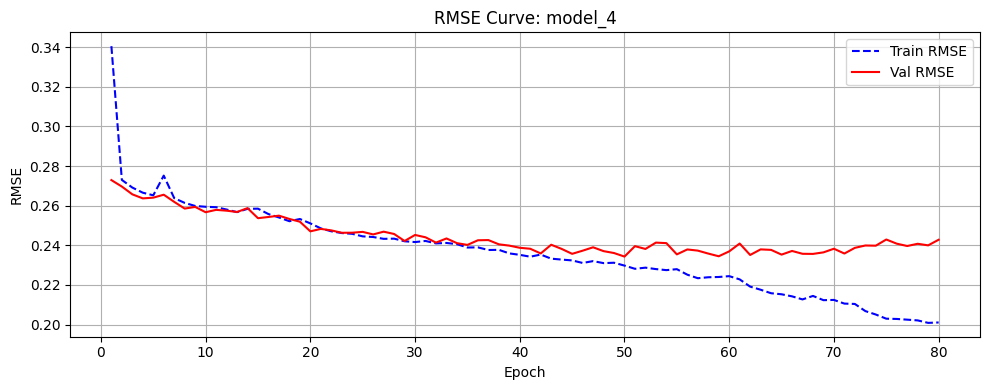


 config: model_5
Epoch 10/100 | model_5 | Train RMSE: 0.2580 | Val RMSE: 0.2575 | LR: 0.001000
Epoch 20/100 | model_5 | Train RMSE: 0.2438 | Val RMSE: 0.2508 | LR: 0.001000
Epoch 30/100 | model_5 | Train RMSE: 0.2360 | Val RMSE: 0.2396 | LR: 0.001000
Epoch 40/100 | model_5 | Train RMSE: 0.2274 | Val RMSE: 0.2392 | LR: 0.001000
Epoch 50/100 | model_5 | Train RMSE: 0.2192 | Val RMSE: 0.2372 | LR: 0.001000
Epoch 60/100 | model_5 | Train RMSE: 0.2044 | Val RMSE: 0.2370 | LR: 0.001000
Epoch 70/100 | model_5 | Train RMSE: 0.1779 | Val RMSE: 0.2419 | LR: 0.000500
Epoch 80/100 | model_5 | Train RMSE: 0.1535 | Val RMSE: 0.2562 | LR: 0.000250
Epoch 90/100 | model_5 | Train RMSE: 0.1420 | Val RMSE: 0.2586 | LR: 0.000125
Epoch 100/100 | model_5 | Train RMSE: 0.1355 | Val RMSE: 0.2605 | LR: 0.000063


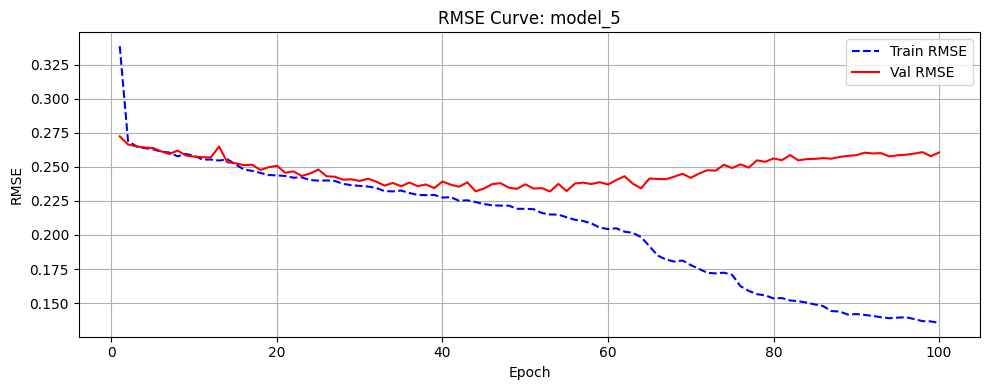


 config: model_6
Epoch 10/60 | model_6 | Train RMSE: 0.2641 | Val RMSE: 0.2686 | LR: 0.001000
Epoch 20/60 | model_6 | Train RMSE: 0.2556 | Val RMSE: 0.2556 | LR: 0.001000
Epoch 30/60 | model_6 | Train RMSE: 0.2455 | Val RMSE: 0.2459 | LR: 0.001000
Epoch 40/60 | model_6 | Train RMSE: 0.2389 | Val RMSE: 0.2408 | LR: 0.001000
Epoch 50/60 | model_6 | Train RMSE: 0.2327 | Val RMSE: 0.2366 | LR: 0.001000
Epoch 60/60 | model_6 | Train RMSE: 0.2276 | Val RMSE: 0.2365 | LR: 0.001000


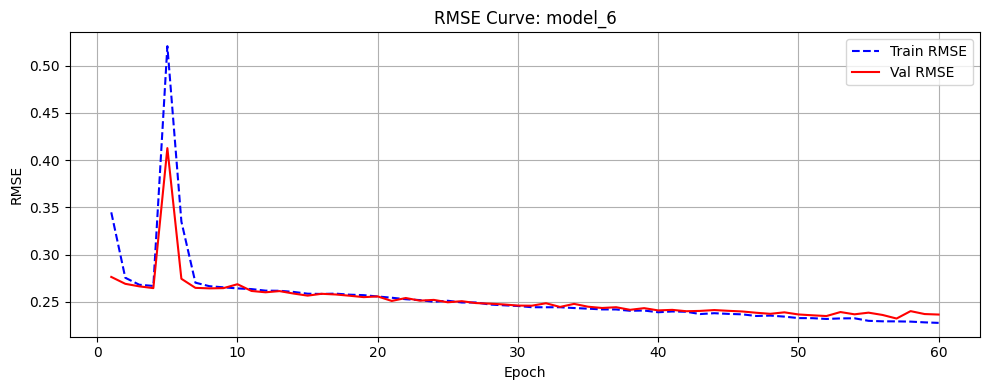


 Final Test RMSEs:
model_1                   - Test RMSE: 0.2498
model_2                   - Test RMSE: 0.2598
model_3                   - Test RMSE: 0.2689
model_4                   - Test RMSE: 0.2462
model_5                   - Test RMSE: 0.2707
model_6                   - Test RMSE: 0.2375


In [28]:
configs = [
    {"name": "model_1","hidden_size": 128, "lr": 1e-3, "epochs": 200, "dropout": 0.2},
    {"name": "model_2","hidden_size": 256, "lr": 1e-3, "epochs": 100, "dropout": 0.2},
    {"name": "model_3","hidden_size": 512, "lr": 1e-3, "epochs": 100, "dropout": 0.2},
    {"name": "model_4","hidden_size": 512, "lr": 1e-3, "epochs": 80, "dropout": 0.3},
    {"name": "model_5","hidden_size": 1024, "lr": 1e-3, "epochs": 100, "dropout": 0.2},
    {"name": "model_6","hidden_size": 1024, "lr": 1e-3, "epochs": 60, "dropout": 0.4},

]
results = experiments(configs)
